In [ ]:

import os
import numpy as np
import random
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

# Import keras modules here
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dense, Activation, MaxPooling2D,Reshape, Conv2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint



# import my google drive
from google.colab import drive
drive.mount('/content/gdrive')

# read fasta files  
fasta_file_path='gdrive/My Drive/data sample/'
rbp_name = 'ELAVL1'
print('list of files', os.listdir(fasta_file_path))



Mounted at /content/gdrive
list of files ['ALKBH5_Baltz2012.test.positives.fasta', 'ALKBH5_Baltz2012.test_negatives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.train.positives.fasta']


## **Loading training set**


In [ ]:
# loading training set
train_fasta = list()
train_label = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'train' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        train_fasta.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        train_label.append(1)
      else:
        train_label.append(0)
     



Processing file... CLIPSEQ_ELAVL1.train.negatives.fasta
Processing file... CLIPSEQ_ELAVL1.train.positives.fasta


**Converting sequence file to one-hot encoding representation**

In [ ]:

# function: fasta to onehot representation
def convert2onehot(sequence_list):
  map = {
      'A':[1,0,0,0],
      'U':[0,1,0,0],
      'T':[0,1,0,0],
      'G':[0,0,1,0],
      'C':[0,0,0,1]
  }
  
  onehot = []
  for single_sequence in sequence_list:
    single_onehot = []
    for x in single_sequence:
      single_onehot.append(map[x.upper()])
    onehot.append(single_onehot)
    
  return np.asarray(onehot, dtype=np.float32)

data_input = convert2onehot(train_fasta)
data_label = keras.utils.to_categorical(train_label, 2)


 **Splitting training and validation dataset from raw dataset (training:validation=8:2)**

In [ ]:
# split training set into train set and validation set
# random shuffling of training data

from sklearn.model_selection import train_test_split

#split training and validation dataset from raw dataset (training:validation=8:2)
train_input, validation_input, train_label, validation_label = train_test_split(data_input, data_label, test_size = 0.2)

print('Dataset preparation done... train_input, train_label, validation_input, validation_label')
print('Size of each set...', train_input.shape, train_label.shape, validation_input.shape, validation_label.shape)



Dataset preparation done... train_input, train_label, validation_input, validation_label
Size of each set... (13240, 200, 4) (13240, 2) (3310, 200, 4) (3310, 2)


In [ ]:
# model building


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Flatten, Dense, Dropout
input = Input(shape=(200, 4))
input2 = Reshape((200, 4, 1))(input)
hidden = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(input2)
hidden = MaxPooling2D((2,2))(hidden)
hidden = Dropout(rate=0.3)(hidden)
hidden = Flatten()(hidden)
output = Dense(2, activation='softmax')(hidden)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()






Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 200, 4)]          0         
_________________________________________________________________
reshape_51 (Reshape)         (None, 200, 4, 1)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 198, 2, 32)        320       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 99, 1, 32)         0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 99, 1, 32)         0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 3168)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 633

In [ ]:
# model training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
earlystop= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
modelcheck = ModelCheckpoint('best_model_ELAVL1.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
train_input.shape
hist_ELAVL1 = model.fit(train_input, train_label, validation_data=(validation_input,validation_label), batch_size=32, epochs=30, verbose=0, callbacks=[earlystop, modelcheck])




Epoch 00001: val_acc improved from -inf to 0.90211, saving model to best_model_ELAVL1.h5

Epoch 00002: val_acc improved from 0.90211 to 0.91843, saving model to best_model_ELAVL1.h5

Epoch 00003: val_acc improved from 0.91843 to 0.92296, saving model to best_model_ELAVL1.h5

Epoch 00004: val_acc did not improve from 0.92296

Epoch 00005: val_acc improved from 0.92296 to 0.92326, saving model to best_model_ELAVL1.h5

Epoch 00006: val_acc did not improve from 0.92326

Epoch 00007: val_acc did not improve from 0.92326

Epoch 00008: val_acc improved from 0.92326 to 0.92538, saving model to best_model_ELAVL1.h5

Epoch 00009: val_acc improved from 0.92538 to 0.92689, saving model to best_model_ELAVL1.h5

Epoch 00010: val_acc did not improve from 0.92689

Epoch 00011: val_acc did not improve from 0.92689

Epoch 00012: val_acc did not improve from 0.92689

Epoch 00013: val_acc did not improve from 0.92689
Epoch 00013: early stopping


**Finally, we draw AUC for our test set**

3310/3310 [==============================] - 0s 142us/sample - loss: 0.2114 - acc: 0.9245


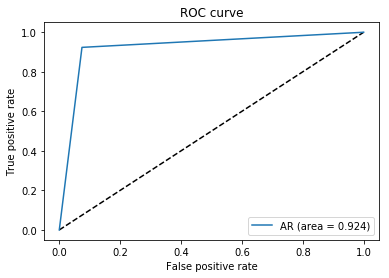

In [ ]:


from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

predict_model = model.predict(validation_input, verbose=1)   #make the prediction using predict function
evaluate_model=model.evaluate(validation_input,validation_label)     #evaluate the model using test set"
AUC=roc_auc_score(validation_label.argmax(axis=1), predict_model.argmax(axis=1)) 
#converting the labels and answers to 1s and 0s to match the input shape of roc_auc_score function

fpr, tpr, thresholds = roc_curve(validation_label.argmax(axis=1), predict_model.argmax(axis=1))
auc_ = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AR (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()




**Now we repeat everything again for ALKBH5 binding protein!**

---



In [ ]:
test_fasta = list()
test_label = list()
rbp_name = 'ALKBH5'
print('list of files', os.listdir(fasta_file_path))

            
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'test' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        test_fasta.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        test_label.append(1)
      else:
        test_label.append(0)
        

test_input = convert2onehot(test_fasta)
test_label = keras.utils.to_categorical(test_label, 2)
print('TEST set prepared...', test_input.shape, test_label.shape)





list of files ['ALKBH5_Baltz2012.test.positives.fasta', 'ALKBH5_Baltz2012.test_negatives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.train.positives.fasta']
Processing file... ALKBH5_Baltz2012.test.positives.fasta
Processing file... ALKBH5_Baltz2012.test_negatives.fasta
TEST set prepared... (262, 200, 4) (262, 2)


In [ ]:
# splitting training set into training set and validation set
# random shuffling of training data

from sklearn.model_selection import train_test_split

#splitting train and validation dataset from raw dataset (training:validation=8:2)
train_input, validation_input, train_label, validation_label = train_test_split(test_input, test_label, test_size = 0.2)

print('Dataset preparation done... train_input, train_label, validation_input, validation_label')
print('Size of each set...', train_input.shape, train_label.shape, validation_input.shape, validation_label.shape)



Dataset preparation done... train_input, train_label, validation_input, validation_label
Size of each set... (209, 200, 4) (209, 2) (53, 200, 4) (53, 2)


In [ ]:
# model building


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Flatten, Dense, Dropout
input = Input(shape=(200, 4))
input2 = Reshape((200, 4, 1))(input)
hidden = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(input2)
hidden = MaxPooling2D((2,2))(hidden)
hidden = Dropout(rate=0.5)(hidden)
hidden = Flatten()(hidden)
output = Dense(2, activation='softmax')(hidden)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 200, 4)]          0         
_________________________________________________________________
reshape_63 (Reshape)         (None, 200, 4, 1)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 198, 2, 64)        640       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 99, 1, 64)         0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 99, 1, 64)         0         
_________________________________________________________________
flatten_62 (Flatten)         (None, 6336)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 126

In [ ]:

# model training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
earlystop= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
modelcheck = ModelCheckpoint('best_model_ALKBH5.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
train_input.shape
hist_ALKBH5 = model.fit(train_input, train_label, validation_data=(validation_input,validation_label), batch_size=20, epochs=10, verbose=0, callbacks=[earlystop, modelcheck])




Epoch 00001: val_acc improved from -inf to 0.37736, saving model to best_model_ALKBH5.h5

Epoch 00002: val_acc improved from 0.37736 to 0.62264, saving model to best_model_ALKBH5.h5

Epoch 00003: val_acc did not improve from 0.62264

Epoch 00004: val_acc did not improve from 0.62264

Epoch 00005: val_acc did not improve from 0.62264

Epoch 00006: val_acc did not improve from 0.62264

Epoch 00007: val_acc did not improve from 0.62264
Epoch 00007: early stopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


53/53 [==============================] - 0s 316us/sample - loss: 0.6974 - acc: 0.5849


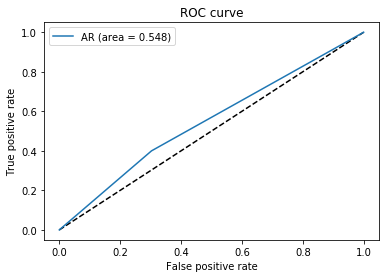

In [ ]:
# calculating AUC score for test sets

predict_model = model.predict(validation_input, verbose=1)   #make the prediction using predict function
evaluate_model=model.evaluate(validation_input,validation_label)     #evaluate the model using test set"
AUC=roc_auc_score(validation_label.argmax(axis=1), predict_model.argmax(axis=1)) 
#converting the labels and answers to 1s and 0s to match the input shape of roc_auc_score function

fpr, tpr, thresholds = roc_curve(validation_label.argmax(axis=1), predict_model.argmax(axis=1))
auc_ = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AR (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
